In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
expr = pd.read_csv(
    "gene_expression_matrix.csv",
    index_col=0
)

# clean gene symbols just in case
expr.index = (
    expr.index
    .astype(str)
    .str.upper()
    .str.strip()
)

print("Expression shape:", expr.shape)
print(expr.index[:10])


Expression shape: (5642, 165)
Index(['A1CF', 'AAAS', 'AACS', 'AADAT', 'AAK1', 'AAMDC', 'AARSD1', 'ABCA1',
       'ABCA13', 'ABCA17P'],
      dtype='object', name='Gene')


In [4]:
labels = pd.read_csv(
    "labels_final.csv",
    index_col=0
)

labels.index = labels.index.astype(str).str.strip()

print("Labels shape:", labels.shape)
print(labels["Label"].value_counts())


Labels shape: (165, 1)
Label
1    147
0     18
Name: count, dtype: int64


In [6]:
common_samples = expr.columns.intersection(labels.index)

expr = expr[common_samples]
labels = labels.loc[common_samples]

print("Aligned expression:", expr.shape)
print("Aligned labels:", labels.shape)


Aligned expression: (5642, 165)
Aligned labels: (165, 1)


In [17]:
degs = pd.read_csv("DEGS.csv")

deg_genes = (
    degs["Genes"]
    .astype(str)
    .str.upper()
    .str.strip()
)

deg_genes = set(deg_genes)
print("Total DEG genes:", len(deg_genes))

Total DEG genes: 1052


In [18]:
PATHWAY_GENES = {
    "WNT": ["DKK3", "WIF1", "WNT2", "WNT5A", "FZD7", "CTNNB1", "FOXA1"],
    "AR": ["AR", "KLK3", "KLK2", "TMPRSS2", "FOXA1"],
    "PI3K": ["PIK3CA", "PIK3R1", "AKT1", "MTOR", "PTEN"],
    "CELL_CYCLE": ["CCND1", "CDK4", "CDK6", "RB1", "E2F1"],
    "METABOLIC": ["FBP1", "PYCR1", "UCK2", "PTGS1"],
    "IMMUNE": ["CD8A", "CD4", "CXCL13", "GZMB", "RORC", "CXCL12", "IL6"],
    "ECM": ["COL1A1", "COL3A1", "MMP9", "DCN", "THBS4", "FN1", "SPARC"]
}

In [19]:
EXPANDED_PATHWAYS = {}

for pathway, genes in PATHWAY_GENES.items():
    base_genes = set(g.upper() for g in genes)
    
    # genes present in expression
    valid_base = base_genes.intersection(expr.index)
    
    # add DEG genes
    valid_deg = deg_genes.intersection(expr.index)
    
    expanded = valid_base.union(valid_deg)
    EXPANDED_PATHWAYS[pathway] = list(expanded)

for p, g in EXPANDED_PATHWAYS.items():
    print(f"{p}: {len(g)} genes")

WNT: 235 genes
AR: 235 genes
PI3K: 235 genes
CELL_CYCLE: 235 genes
METABOLIC: 234 genes
IMMUNE: 234 genes
ECM: 235 genes


In [20]:
pathway_scores = pd.DataFrame(index=expr.columns)

for pathway, genes in EXPANDED_PATHWAYS.items():
    valid_genes = [g for g in genes if g in expr.index]
    
    if len(valid_genes) < 3:
        print(f"⚠️ Skipping {pathway} (too few genes)")
        continue
    
    pathway_scores[pathway] = expr.loc[valid_genes].median(axis=0)

print("Pathway score matrix:", pathway_scores.shape)
pathway_scores.head()

Pathway score matrix: (165, 7)


,WNT,AR,PI3K,CELL_CYCLE,METABOLIC,IMMUNE,ECM
"""GSM152839""",135.9,135.9,135.9,135.9,135.250,135.250,134.6
"""GSM152840""",182.4,182.4,182.4,182.4,180.475,180.475,182.4
"""GSM152841""",176.5,176.5,176.5,176.5,175.150,175.150,173.8
"""GSM152842""",145.7,145.7,145.7,145.7,145.700,145.700,145.7
"""GSM152843""",144.2,144.2,144.2,144.2,140.750,140.750,137.3


In [21]:
X = pathway_scores
y = labels["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [22]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [24]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

Accuracy: 0.6363636363636364
ROC-AUC: 0.646551724137931
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         4
           1       1.00      0.59      0.74        29

    accuracy                           0.64        33
   macro avg       0.62      0.79      0.57        33
weighted avg       0.91      0.64      0.70        33



In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc = cross_val_score(
    pipe,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("CV ROC-AUC:", cv_auc.mean(), "+/-", cv_auc.std())

CV ROC-AUC: 0.6244827586206896 +/- 0.12445506060449629


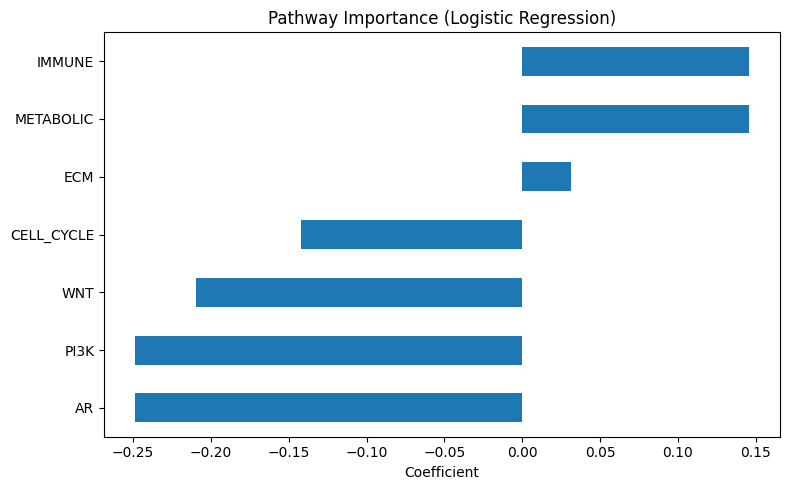

In [30]:
importance = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values()

plt.figure(figsize=(8,5))
importance.plot(kind="barh")
plt.title("Pathway Importance (Logistic Regression)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [33]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)

ROC AUC: 0.646551724137931


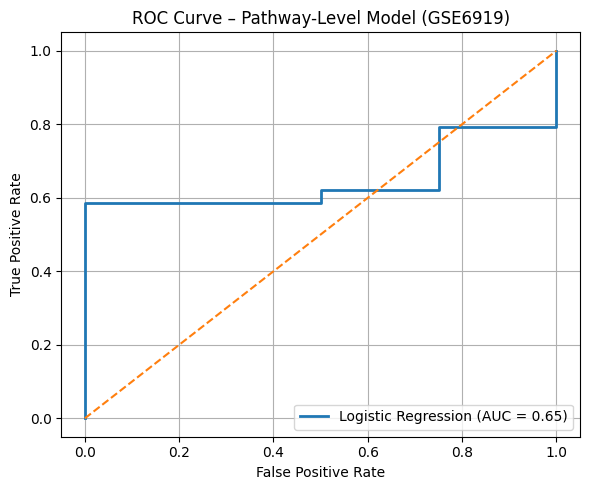

In [34]:
plt.figure(figsize=(6, 5))

plt.plot(
    fpr,
    tpr,
    label=f"Logistic Regression (AUC = {roc_auc:.2f})",
    linewidth=2
)

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Pathway-Level Model (GSE6919)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
pathway_scores.to_csv("pathway_expression_matrix.csv")

print("Saved:")
print("- pathway_expression_matrix.csv")

Saved:
- pathway_expression_matrix.csv


In [51]:
elastic_model = LogisticRegression(
    penalty="elasticnet",                                                    #ElasticNet Logistic
    solver="saga",
    l1_ratio=0.5,          # 0 = Ridge, 1 = Lasso
    max_iter=3000,
    class_weight="balanced",
    random_state=42
)

elastic_model.fit(X_train_scaled, y_train)

C:\Users\yash darji\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'elasticnet'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.5
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [52]:
y_pred_elastic = elastic_model.predict(X_test_scaled)
y_prob_elastic = elastic_model.predict_proba(X_test_scaled)[:, 1]

In [53]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("ElasticNet Accuracy:", accuracy_score(y_test, y_pred_elastic))
print("ElasticNet ROC-AUC:", roc_auc_score(y_test, y_prob_elastic))
print(classification_report(y_test, y_pred_elastic))

ElasticNet Accuracy: 0.6363636363636364
ElasticNet ROC-AUC: 0.646551724137931
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         4
           1       1.00      0.59      0.74        29

    accuracy                           0.64        33
   macro avg       0.62      0.79      0.57        33
weighted avg       0.91      0.64      0.70        33



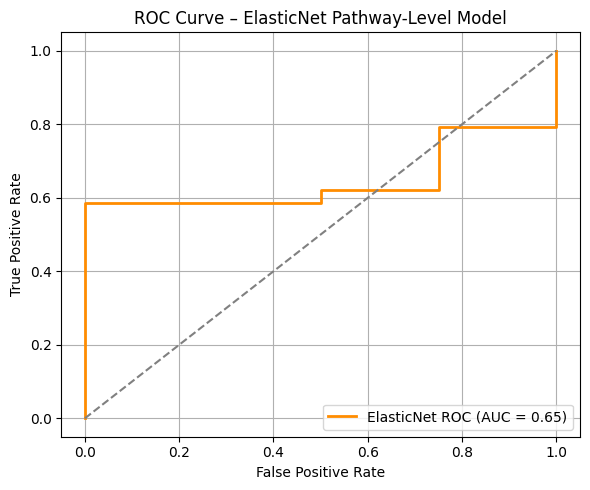

In [54]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_elastic)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label=f"ElasticNet ROC (AUC = {roc_auc:.2f})"
)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – ElasticNet Pathway-Level Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [49]:
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

XGBoost ROC-AUC: 0.8362068965517241


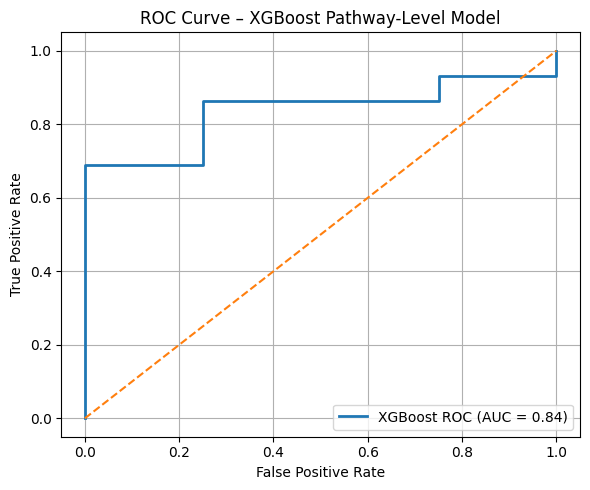

In [55]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(
    fpr,
    tpr,
    lw=2,
    label=f"XGBoost ROC (AUC = {roc_auc:.2f})"
)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost Pathway-Level Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

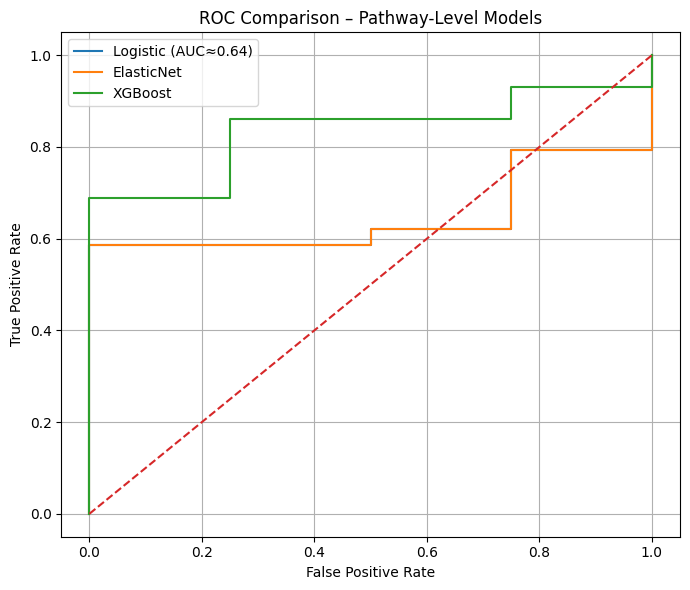

In [50]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
fpr_el, tpr_el, _ = roc_curve(y_test, y_prob_elastic)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label="Logistic (AUC≈0.64)")
plt.plot(fpr_el, tpr_el, label="ElasticNet")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot([0,1], [0,1], "--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison – Pathway-Level Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()